# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [4]:
# Show datatypes
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

Most of the variables seem to have appropriate means and ranges. However, the maximum of windspeed is 0.85 when the windspeed variable is supposed to be normalized, meaning that the maximum windspeed value should be 1. Also, the minimum value for temperature is 0.02 when it should be 1 since the variable is normalized.

Also, although the ranges for the number of rides per hour by causal and registered users are quite large at 0 to 367 and 0 to 886, respectively, these ranges are plausible because the registered users still have a much larger maximum (886) and average (154) number of rides per hour compared to causal users (maximum of 367 and average of 36 rides). It is noteworthy that the mean is not in the center of the range for the variables causal and registered. It is possible (but not guarenteed) that there are high outliers with large positive values for causal and registered influencing the range of these variables.

It is also noteworthy that workingday is provided as a variable in the dataset but is not described in the overview section of the problem. The variable dteday is not included in the "describe" table because it is an object that is not currently amenable to the .describe method for dataframes.

The datatypes appear to be appropirate as well, since all the categorical variables are integers while continuous variables are floats. The variable dteday is a pandas object (showing a date as YYYY-MM-DD), which may not be useful for analysis but does confirm that the data are provided in a way that is consistent with how they are described. The variables temp, atemp, hum, and windspeed are all normalized so they ought to be floats as shown. 

**1.2 Notice that the variable in column...**

In [5]:
# Convert dteday to datetime object
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'])
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


**1.3 Create three new columns in the dataframe:...**

In [6]:
# Modifying year and month columns, creating Counts column summing casual and registered
bikes_df_raw['year'] = pd.DatetimeIndex(bikes_df_raw['dteday']).year - 2011
bikes_df_raw['month'] = pd.DatetimeIndex(bikes_df_raw['dteday']).month
bikes_df_raw['counts'] = bikes_df_raw['casual'] + bikes_df_raw['registered']
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.7.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [7]:
# Defining functions to apply to columns
def f(x):
    d = {}
    d['month'] = x['month'].max()
    d['weekday'] = x['weekday'].max()
    d['weather'] = x['weather'].max()
    d['season'] = x['season'].max()
    d['temp'] = x['temp'].mean()
    d['atemp'] = x['atemp'].mean()
    d['windspeed'] = x['windspeed'].mean()
    d['hum'] = x['hum'].mean()
    d['casual'] = x['casual'].sum()
    d['registered'] = x['registered'].sum()
    d['counts'] = x['counts'].sum()
    return pd.Series(d, index=['month','weekday', 'weather', 'season', 'temp', 'atemp', 'windspeed', 'hum', 'casual', 'registered', 'counts'])

# Grouping by dteday and applying functions to columns
bikes_by_day = bikes_df_raw.groupby('dteday').apply(f)
bikes_by_day.head()

,month,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,,
2011-01-01,1.0,6.0,3.0,1.0,0.344167,0.363625,0.160446,0.805833,331.0,654.0,985.0
2011-01-02,1.0,0.0,3.0,1.0,0.363478,0.353739,0.248539,0.696087,131.0,670.0,801.0
2011-01-03,1.0,1.0,1.0,1.0,0.196364,0.189405,0.248309,0.437273,120.0,1229.0,1349.0
2011-01-04,1.0,2.0,2.0,1.0,0.200000,0.212122,0.160296,0.590435,108.0,1454.0,1562.0
2011-01-05,1.0,3.0,1.0,1.0,0.226957,0.229270,0.186900,0.436957,82.0,1518.0,1600.0


/Users/williamdrew/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


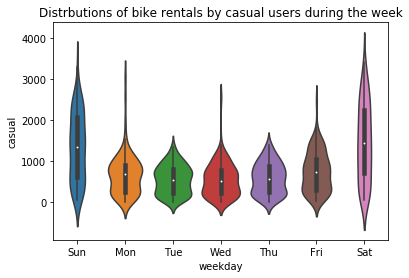

In [8]:
# Plotting violinplots of casual riders
ax = sns.violinplot(x="weekday", y="casual", data=bikes_by_day);
ax.set_title('Distrbutions of bike rentals by casual users during the week');
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']);

/Users/williamdrew/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


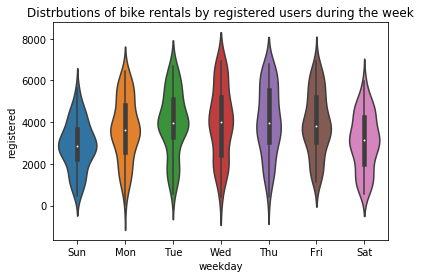

In [9]:
# Plotting violinplots of registered riders
ax = sns.violinplot(x="weekday", y="registered", data=bikes_by_day);
ax.set_title('Distrbutions of bike rentals by registered users during the week');
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']);

**2.2 Use `bikes_by_day` to visualize how the distribution...**

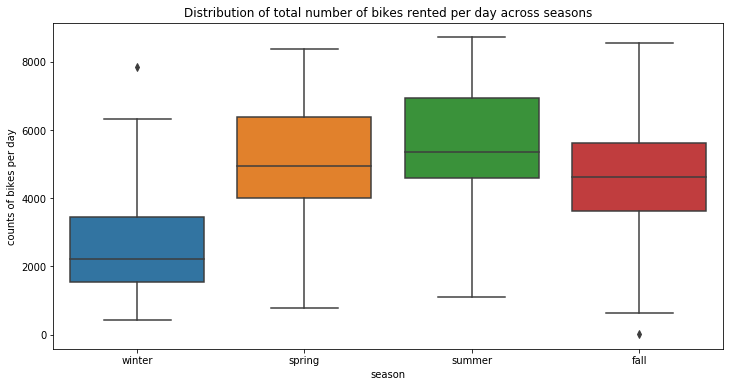

In [10]:
# Plot boxplots of riders per season, shows outliers
fig, ax = plt.subplots(figsize=(12,6));
sns.boxplot(x="season", y="counts", data=bikes_by_day);
ax.set_title('Distribution of total number of bikes rented per day across seasons');
ax.set_xticklabels(['winter', 'spring', 'summer', 'fall']);
ax.set_ylabel('counts of bikes per day');

In [11]:
# find the high outlier in the winter
index_max = bikes_by_day[bikes_by_day['season']==1]['counts'].idxmax()
print("THIS IS THE HIGH OUTLIER IN THE WINTER")
display(index_max)
display(bikes_by_day.loc[index_max, :])

THIS IS THE HIGH OUTLIER IN THE WINTER


Timestamp('2012-03-17 00:00:00')

month            3.000000
weekday          6.000000
weather          2.000000
season           1.000000
temp             0.514167
atemp            0.505046
windspeed        0.110704
hum              0.755833
casual        3155.000000
registered    4681.000000
counts        7836.000000
Name: 2012-03-17 00:00:00, dtype: float64

In [12]:
# find the low outlier in the fall
index_min = bikes_by_day[bikes_by_day['season']==4]['counts'].idxmin()
print("THIS IS THE LOW OUTLIER IN THE FALL")
display(index_min)
display(bikes_by_day.loc[index_min, :])

THIS IS THE LOW OUTLIER IN THE FALL


Timestamp('2012-10-29 00:00:00')

month         10.0000
weekday        1.0000
weather        3.0000
season         4.0000
temp           0.4400
atemp          0.4394
windspeed      0.3582
hum            0.8800
casual         2.0000
registered    20.0000
counts        22.0000
Name: 2012-10-29 00:00:00, dtype: float64

From this boxplot, we observe two outliers, one in winter (season = 1) and one in fall (season = 4). 

The outlier in Winter is on March 17, 2012, during which there were 7836 total rides. This was on St. Patrick's Day (https://obamawhitehouse.archives.gov/blog/2012/03/17/president-obama-dubliner-st-patricks-day), and was also the date of a demonstration in front of the White House for the first anniversary of the Syrian Revolution, which could have contributed to the higher number of bike rentals this day. Furthermore, Obama was holding a celebratory St. Patrick's Day event, which could have drawn crowds. St. Patrick's Day is a popular day for parades and roads may have been closed to drivers, making bike rentals a popular choice for transportation. obama was having a celebratory event in DC that day which may have drew crowds

The outlier in Fall is on October 29, 2012, during which there were 22 total rides. Considering the number of bike rentals the days surrounding October 10, 2012, it seems like this unusually low number may be due to there being thunderstorms that day according to the weather attribute. Looking online, it appears that on that date Hurricane Sandy hit Washington DC (https://theweek.com/articles/470962/10-things-need-know-today-october-29-2012), which would make travel by bike dangerous such that bike rentals were low for both casual and registered users.

**2.3 Convert the categorical attributes...**

In [13]:
# Setting one-hot encodings, dropping one column from each group
bikes_df = pd.get_dummies(bikes_by_day, columns = ['season', 'month', 'weekday', 'weather'], prefix = ['season', 'month', 'weekday', 'weather'])
bikes_df['month_stratify'] = bikes_by_day['month']
bikes_df.head()

,temp,atemp,windspeed,hum,casual,registered,counts,season_1.0,season_2.0,season_3.0,...,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weather_1.0,weather_2.0,weather_3.0,weather_4.0,month_stratify
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.344167,0.363625,0.160446,0.805833,331.0,654.0,985.0,1,0,0,...,0,0,0,0,1,0,0,1,0,1.0
2011-01-02,0.363478,0.353739,0.248539,0.696087,131.0,670.0,801.0,1,0,0,...,0,0,0,0,0,0,0,1,0,1.0
2011-01-03,0.196364,0.189405,0.248309,0.437273,120.0,1229.0,1349.0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0
2011-01-04,0.200000,0.212122,0.160296,0.590435,108.0,1454.0,1562.0,1,0,0,...,1,0,0,0,0,0,1,0,0,1.0
2011-01-05,0.226957,0.229270,0.186900,0.436957,82.0,1518.0,1600.0,1,0,0,...,0,1,0,0,0,1,0,0,0,1.0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [14]:
bikes_train, bikes_test = train_test_split(bikes_df, test_size=0.5, stratify = bikes_df['month_stratify'], random_state=90)

**2.5 Although we asked you to create your train and test set...**

In [7]:
# Read in train and test sets
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")
BSS_train = BSS_train.drop(columns = ['dteday'])
BSS_test = BSS_test.drop(columns = ['dteday'])
BSS_train.keys()

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

**2.6 Use pandas' `scatter_matrix` command to visualize...**

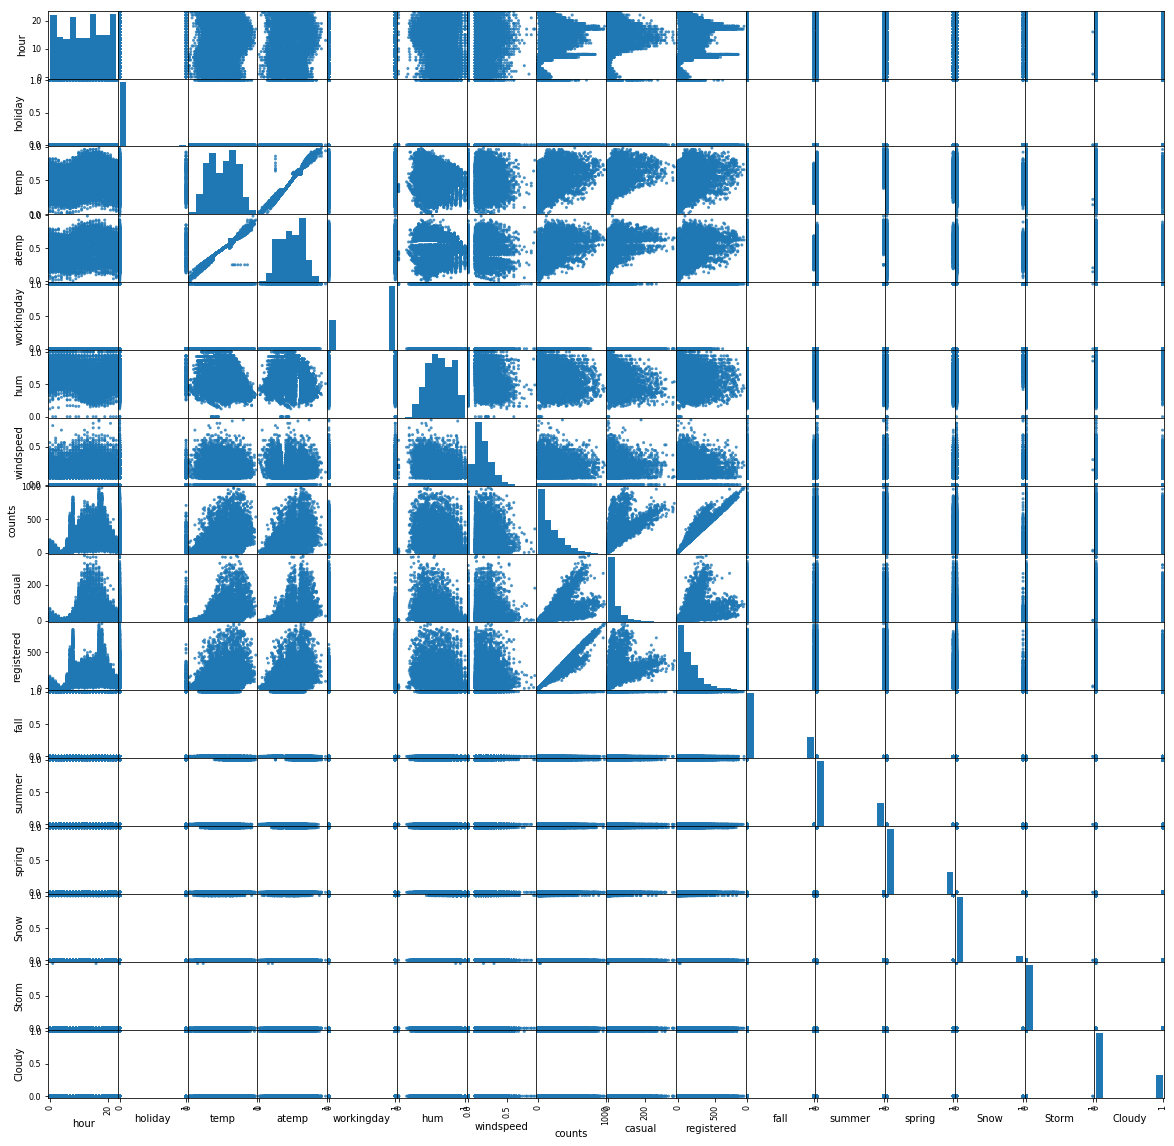

In [16]:
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed', 'counts', 'casual', 'registered', 'fall', 'summer', 'spring', 'Snow', 'Storm', 'Cloudy']
df_to_plot = BSS_train.loc[:,cor_columns]
# Plot scatter matrix
scatter_matrix(df_to_plot, alpha=0.8, figsize=(20, 20)); 

We observe that temp and atemp are highly positively correlated as evidenced by the diagonal shape with positve slope in the scatterplot of the cell with "coordinates" in the scatter matrix of (x, y) = (atemp, temp) = (temp, atemp). We also notice that counts is positively correlated with both registered and casual users (more positively correlated with registered users but there is a positive slope for both pairs).

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

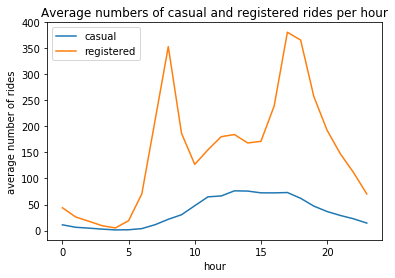

In [17]:
average_riders = BSS_train.groupby('hour').agg({'casual':np.mean, 'registered':np.mean});
ax = average_riders.plot(title = 'Average numbers of casual and registered rides per hour');
ax.set_ylabel('average number of rides');

We observe very differently shaped distributions for casual and registered users. For casual users, their use peaks in the afternoon around 3pm (probably tourists using bikes), while registered users peak in the morning and afternoon around the times when people go to and leave work (8am and 5pm, respectively). It is noteworthy that the registered users have overall more bike rentals (orange points generally have greater magnitudes than the blue points for each hour) through the day. The average number of registered users has more rapid changes in the number of rides (where the number of rides rises rapidly from 5am to 8am then drops rapidly from 8am to 10am, climbing gradully from 10am to 3pm at which point it rises rapidly from 3pm to 5pm and then drops rapidly from 5pm to midnight) than does the average number of rides for casual users.

**2.8 Use the weather related variables to show how each weather...** 

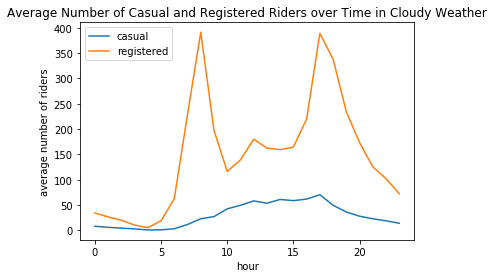

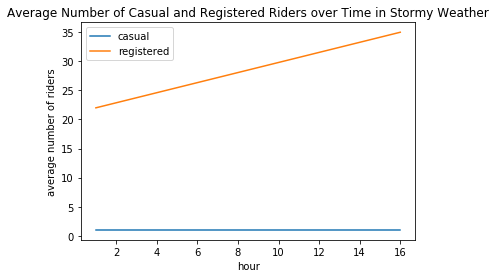

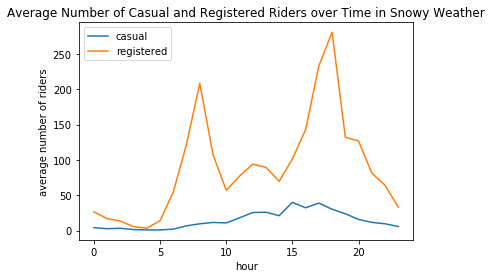

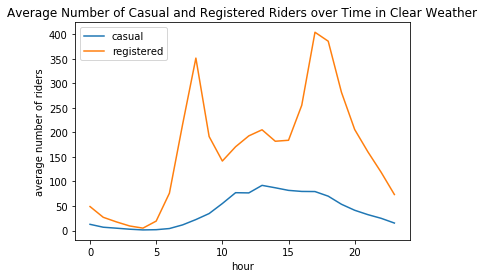

In [18]:
average_riders_cloudy = BSS_train[BSS_train['Cloudy'] == 1].groupby('hour').agg({'casual':np.mean, 'registered':np.mean})
average_riders_storm = BSS_train[BSS_train['Storm'] == 1].groupby('hour').agg({'casual':np.mean, 'registered':np.mean})
average_riders_snow = BSS_train[BSS_train['Snow'] == 1].groupby('hour').agg({'casual':np.mean, 'registered':np.mean})
# Get Clear as reference group, all other variables are 0
average_riders_clear = BSS_train[BSS_train['Snow']+BSS_train['Cloudy']+BSS_train['Storm'] == 0].groupby('hour').agg({'casual':np.mean, 'registered':np.mean})

average_riders_cloudy.plot()
plt.title("Average Number of Casual and Registered Riders over Time in Cloudy Weather");
plt.ylabel("average number of riders");
average_riders_storm.plot()
plt.title("Average Number of Casual and Registered Riders over Time in Stormy Weather");
plt.ylabel("average number of riders");
average_riders_snow.plot()
plt.title("Average Number of Casual and Registered Riders over Time in Snowy Weather");
plt.ylabel("average number of riders");
average_riders_clear.plot()
plt.title("Average Number of Casual and Registered Riders over Time in Clear Weather");
plt.ylabel("average number of riders");

We observe that the shape of the distributions of the types of riders (casual and registered) doesn't really change between Cloudy, Snowy, and Clear weather (all of these plots for registerd users show peaks around 8am and 5pm and for casual users show gradual increase until around 3pm as described in question 2.7), although the volume of riders does decrease in Snowy weather compared to Clear and Cloudy weather. In Stormy weather, we only have two datapoints each for casual and registered users, so we cannot really determine a distribution shape across time. But we do observe that very few people use the bikeshare when it is stormy outside. 

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [8]:
params = ['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum','windspeed', 'spring', 'summer', 
                     'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 
                     'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
# Allowing for intercept
X_train = sm.add_constant(BSS_train[params])
X_test = sm.add_constant(BSS_test[params])

y_train = BSS_train['counts']
y_test = BSS_test['counts']
model = sm.OLS(y_train, X_train).fit()

print("The R^2 score on the train set is: " + str(r2_score(y_train, model.predict(X_train))))
print("The R^2 score on the test set is: " + str(r2_score(y_test, model.predict(X_test))))

The R^2 score on the train set is: 0.4115699822629325
The R^2 score on the test set is: 0.40072109229413466


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**3.2 Examine the estimated coefficients and report...**

In [20]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:33:13   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.0

The statistically significant coefficients are those for the constant, hour, holiday, year, workingday, temp, atemp, hum, spring, summer, fall, Apr, May, Jun, Jul, Aug, Nov, Dec, Sat, and Snow variables since the p values associated with these beta estimates are less than 0.05.

**3.3 You should see some strange estimates for the predictors representing months...** 

The July coefficient is -90.89, implying that being in July is associated with having approximately 91 fewer rides compared to if it was Janurary (January is the reference group) assuming that all other variables are held constant. This coefficient large in its magnitude is likely occurring due to multicollinearity since we expect the month predictor variables to be correlated with other predictor variables such as the accompanying season predictor variables also included in the model. This is a problem since a linear regression assumes the predictor variables are independent, which the month predictor variables definitely aren't. This causes the coefficients to become very sensitive to small changes in the model.

**3.4 To diagnose the model, make two plots:...**

Text(0,0.5,'Frequency')

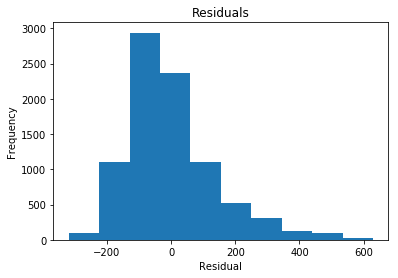

In [21]:
# Plotting histogram of the residuals
plt.title("Residuals")
plt.hist(y_train - model.predict(X_train))
plt.xlabel("Residual")
plt.ylabel("Frequency") #mean has to be 0. r skewed histogram/ interpret this way

Text(0.5,1,'Residuals as a function of the Predicted Value')

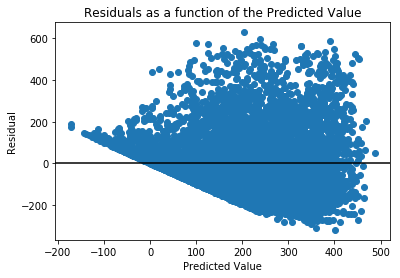

In [22]:
plt.scatter(model.predict(X_train), y_train - model.predict(X_train), label="Residual")
plt.axhline(0, color='k')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residuals as a function of the Predicted Value")

The histogram of residuals versus frequency shows that the residuals are not normally distributed and instead are skewed to the right. 

The scatter plot of the predicted values versus the residuals shows that the residuals are not randomly distributed around 0 (the horizontal line y=0). This tells us that the OLS assumption about normality of the error term does not hold for this data. The error term also does not have constant variance (error term having constant variance is another assumption of linear regression), which is apparent from the scatter plot since as the predicted value increases the variability in the residual also increases (scatter plot widens). 

The scatter plot of predicted values versus the residuals also shows that the assumption of linearity likely does not hold since there is a pattern in the residuals (they are not randomly scattered around the y=0 line). We observe that there is a line with negative slope in the bottom left portion of the data, which is due to the fact that counts cannot be negative but we are predicting negative counts (so if prediction is -100 then residual must be >= 100). 

Furthermore, the assumption of linearity is more directly evaluated in the scatterplots of each predictor with the response variable as shown in question 2.6, and we see that none of the predictors included in the model have even a generally linear relationship with the response variable (counts). Thus, the assumptions of linear regression do not fully hold for this data. 


**3.5 Perhaps we can do better via a model...**

In [9]:
X_train_poly = X_train.copy()
# Add squared terms
X_train_poly['temp2'] = X_train['temp']**2
X_train_poly['hour2'] = X_train['hour']**2
X_train_poly['hum2'] = X_train['hum']**2

BSS_poly_model = sm.OLS(y_train, X_train_poly).fit()
print(BSS_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:42:47   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.0

The polynomial terms for $temp^2$, $hour^2$, and $hum^2$ are important as their p-values are < 0.05. 

For every unit increase in squared normalized temperature, all other variables held constant, the number of riders increases by ~141. 

For every unit increase in squared normalized hour, all other variables held constant, the number of riders decreases by ~1.4. 

For every unit increase in squared normalized humidity, all other variables held constant, the number of riders decreases by ~127.

Overall, as temperature increases, ridership increases. As humidity increases, ridership decreases. As hour increases, ridership initially rises, then decreases when combining both polynomial terms of hour (both the degree 1 and 2 terms for hour are statistically significant predictors but have opposite signs, indicating that there is an initial rise and subsequent fall).

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [10]:
# Dropping columns and retraining
X_train_drop = X_train.drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
BSS_model_drop = sm.OLS(y_train, X_train_drop).fit()
print(BSS_model_drop.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:42:51   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.0

The estimates are more reasonable in this model since we dropped the seasonal attributes that correlated with month. Multicollinearity can lead to erroneous coefficient values because collinear terms will not contribute much new information to the regression model, so as one term's coefficient rises, the other term's coefficient must decrease accordingly to keep the overall effect nominal. 

The model is trying to partition the information for the effects of the collinear terms on the response into just one of the terms since the extra terms don't provide much new information. However, as the effect of these two predictors is attributed to just one of them, the beta estimate for the other collinear predictor is driven in the opposite direction. As a result, the pair of predictors have extreme beta values that are opposite of each other, so that the beta estimate for each predictor is independent of the other predictors in the model.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [11]:
BSS_train = BSS_train.drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
BSS_test = BSS_test.drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
# Drop columns from X_train for testing
X_train = X_train.drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
BSS_train.head()

,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,Feb,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,0.24,0.60,0.2537,12,51,63,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,0.62,0.83,0.2537,47,432,479,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,0.76,0.66,0.1642,54,299,353,0,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0.62,0.22,0.2985,185,226,411,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0.18,0.40,0.1343,9,61,70,0,...,0,0,0,0,0,0,0,0,0,0


**4.2 Write a function to standardize...**

In [12]:
def make_standardized_df(train, test, excluded_cols = [ 'const','holiday', 'workingday','Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring', 'summer', 
                  'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 
                  'Snow', 'Storm']):
    # Manually standardizing instead of using StandardScaler
    train_standard_cols = train[train.columns.difference(excluded_cols)]
    test_standard_cols = test[test.columns.difference(excluded_cols)]
    for i in train_standard_cols.keys():
        mean = train_standard_cols[i].mean()
        stdev = train_standard_cols[i].std()
        train_standard_cols[i] = (train_standard_cols[i] - mean)/stdev
        test_standard_cols[i] = (test_standard_cols[i] - mean)/stdev
    train.update(train_standard_cols)
    test.update(test_standard_cols)
    return train, test

In [13]:
practice_X_train = X_train.copy()
practice_X_test = X_test.copy()
practice_X_train_scaled, practice_X_test_scaled = make_standardized_df(practice_X_train, practice_X_test)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [14]:
practice_X_train_scaled.describe()

,const,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8689.0,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,1.0,7.326526e-17,0.029347,1.077015e-15,1.180187e-14,3.874411e-14,7.452489e-14,0.077224,0.084705,0.082748,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,0.0,1.000000e+00,0.168788,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.266962,0.278458,0.275517,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,1.0,-1.666263e+00,0.000000,-1.006755e+00,-2.474050e+00,-3.251787e+00,-1.546547e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,-8.042200e-01,0.000000,-1.006755e+00,-8.122357e-01,-7.554373e-01,-6.986934e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,5.782341e-02,0.000000,9.931755e-01,1.867126e-02,-2.733539e-02,2.745877e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,9.198668e-01,0.000000,9.931755e-01,8.495782e-01,8.047811e-01,5.118307e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.0,1.638236e+00,1.000000,9.931755e-01,2.511392e+00,1.948941e+00,5.355550e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [15]:
def add_higher_order_polynomial_terms(df, cols_to_add, degree):
    df = df.copy()
    cols = df.loc[:,cols_to_add].columns.copy()
    for col in cols:
        for i in range(2, degree+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

In [16]:
cols_to_add = ['temp', 'hum','windspeed','hour']
practice_X_train_poly = add_higher_order_polynomial_terms(practice_X_train_scaled, cols_to_add, 3)

In [17]:
print(practice_X_train_poly.columns)
practice_X_train_poly.head()

Index(['const', 'hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm',
       'temp^2', 'temp^3', 'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3',
       'hour^2', 'hour^3'],
      dtype='object')


,const,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,...,Snow,Storm,temp^2,temp^3,hum^2,hum^3,windspeed^2,windspeed^3,hour^2,hour^3
0,1.0,1.350889,0,0.993176,-1.331553,-0.131350,0.511831,0,0,0,...,0,0,1.773032,-2.360885,0.017253,-0.002266,0.261971,0.134085,1.824900,2.465236
1,1.0,0.776193,0,-1.006755,0.641851,1.064817,0.511831,0,0,0,...,1,0,0.411973,0.264426,1.133836,1.207329,0.261971,0.134085,0.602475,0.467637
2,1.0,-0.373198,0,0.993176,1.368895,0.180694,-0.214322,0,0,0,...,0,0,1.873874,2.565136,0.032650,0.005900,0.045934,-0.009845,0.139277,-0.051978
3,1.0,0.776193,0,0.993176,0.641851,-2.107627,0.875312,0,0,1,...,0,0,0.411973,0.264426,4.442090,-9.362266,0.766172,0.670640,0.602475,0.467637
4,1.0,-0.516872,0,0.993176,-1.643143,-1.171496,-0.456913,0,0,0,...,0,0,2.699918,-4.436350,1.372402,-1.607762,0.208770,-0.095390,0.267157,-0.138086


**4.4 Write code to add interaction terms to the model...**

In [18]:
def add_interactive_terms(df):
    df = df.copy()
    cols_continuous = ['temp','hum','windspeed']
    cols_dummy = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
                  'Oct', 'Nov', 'Dec', 'Mon', 'Tue','Wed', 'Thu', 'Fri', 'Sat']
    
    for col1 in cols_continuous:
        for col2 in cols_dummy:
            df['{}*{}'.format(col1, col2)] = df[col1]*df[col2]
    return df

In [19]:
practice_X_train_poly_interaction = add_interactive_terms(practice_X_train_poly)
print(practice_X_train_poly_interaction.columns)
practice_X_train_poly_interaction.head()     #should these have hour, and other varibales here not just continuous, dummy??

Index(['const', 'hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm',
       'temp^2', 'temp^3', 'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3',
       'hour^2', 'hour^3', 'temp*Feb', 'temp*Mar', 'temp*Apr', 'temp*May',
       'temp*Jun', 'temp*Jul', 'temp*Aug', 'temp*Sept', 'temp*Oct', 'temp*Nov',
       'temp*Dec', 'temp*Mon', 'temp*Tue', 'temp*Wed', 'temp*Thu', 'temp*Fri',
       'temp*Sat', 'hum*Feb', 'hum*Mar', 'hum*Apr', 'hum*May', 'hum*Jun',
       'hum*Jul', 'hum*Aug', 'hum*Sept', 'hum*Oct', 'hum*Nov', 'hum*Dec',
       'hum*Mon', 'hum*Tue', 'hum*Wed', 'hum*Thu', 'hum*Fri', 'hum*Sat',
       'windspeed*Feb', 'windspeed*Mar', 'windspeed*Apr', 'windspeed*May',
       'windspeed*Jun', 'windspeed*Jul', 'windspeed*Aug', 'windspeed*Sept',
       'windspeed*Oct', 'windspeed*Nov', 'windspeed*Dec', 'windspeed*Mon',
       'wind

,const,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
0,1.0,1.350889,0,0.993176,-1.331553,-0.131350,0.511831,0,0,0,...,0.0,0.000000,0.0,0.511831,0.0,0.0,0.0,0.511831,0.0,0.0
1,1.0,0.776193,0,-1.006755,0.641851,1.064817,0.511831,0,0,0,...,0.0,0.511831,0.0,0.000000,0.0,0.0,0.0,0.511831,0.0,0.0
2,1.0,-0.373198,0,0.993176,1.368895,0.180694,-0.214322,0,0,0,...,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.214322,-0.0,-0.0
3,1.0,0.776193,0,0.993176,0.641851,-2.107627,0.875312,0,0,1,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,1.0,-0.516872,0,0.993176,-1.643143,-1.171496,-0.456913,0,0,0,...,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0


**4.5 Combine all your code so far into a function named...**

In [20]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts','casual', 'registered','workingday', 'atemp', 'spring', 'summer', 'fall']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    # Adding intercepts
    train = sm.add_constant(train_df.drop(columns = bad_columns))
    val = sm.add_constant(val_df.drop(columns = bad_columns))
    train, val = make_standardized_df(train, val)
    train = add_higher_order_polynomial_terms(train, columns_forpoly, degree)
    val = add_higher_order_polynomial_terms(val, columns_forpoly, degree)
    train = add_interactive_terms(train)
    val = add_interactive_terms(val)
    
    x_train = train
    x_val = val
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    
    return x_train,y_train, x_val,y_val

**4.6 For each degree in 1 through 8...**

For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

In [21]:
for degree in range(1,9):
    # Dropping bad columns registered and casual because they are directly related to counts
    x_train, y_train, x_val, y_val = get_design_mats(BSS_train, BSS_test, degree, bad_columns=['casual', 'registered','counts']);
    model = sm.OLS(y_train, x_train).fit();
    print("Model Score on test data for degree ",degree,": ", str(r2_score(y_val, model.predict(x_val))));

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  1 :  0.42919370152715897


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  2 :  0.5121988354655904


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  3 :  0.5612705475559349


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  4 :  0.5643812587064101


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  5 :  0.5760635265312037


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  6 :  0.5990042016659392


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  7 :  0.6337668811584173


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Model Score on test data for degree  8 :  0.6433746024488687


In [27]:
y_train.shape

(8689,)

**4.7 Discuss patterns you see in the results...**

We observe that the $R^2$ values increase consistently as the degree increases. As the degreee increases, the number of predictors increases and therefore the model becomes more fit to the training data. Through degree 8, the model is not overfitting to the training data as the $R^2$ on the test data is still increasing.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above?

### Answers

**5.1 Let's try regularizing our models via...** 

In [36]:
BSS_train_train, BSS_train_val = train_test_split(BSS_train, train_size = 0.8, random_state = 90)
lambdas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
table = {}
for i in range(0,9):
    x_train, y_train, x_val, y_val = get_design_mats(BSS_train_train, BSS_train_val, i, bad_columns=['casual', 'registered','counts'])
    scores = []
    for j in lambdas:
        ridge_model = Ridge(alpha = j).fit(x_train, y_train)
        scores.append(ridge_model.score(x_val, y_val))
    table['degree '+str(i)] = scores

/Users/williamdrew/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/williamdrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/williamdrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0

In [37]:
score_table = pd.DataFrame(data = table)
score_table.index = lambdas
score_table.index.name = "Lambda"
score_table

,degree 0,degree 1,degree 2,degree 3,degree 4,degree 5,degree 6,degree 7,degree 8
Lambda,,,,,,,,,
0.01,0.440161,0.440161,0.519979,0.559744,0.562069,0.577847,0.599372,0.639927,0.649689
0.05,0.440155,0.440155,0.519988,0.559753,0.562079,0.577854,0.599382,0.639942,0.649710
0.10,0.440147,0.440147,0.519998,0.559764,0.562091,0.577864,0.599395,0.639960,0.649731
0.50,0.440083,0.440083,0.520064,0.559844,0.562178,0.577931,0.599487,0.640047,0.649712
1.00,0.440003,0.440003,0.520119,0.559934,0.562273,0.577999,0.599577,0.640035,0.649351
5.00,0.439535,0.439535,0.520226,0.560430,0.562736,0.578248,0.599823,0.637493,0.642628
10.00,0.439206,0.439206,0.520166,0.560787,0.563017,0.578301,0.599572,0.632612,0.634412
50.00,0.437486,0.437486,0.519247,0.560747,0.562610,0.577194,0.594123,0.608154,0.607220
100.00,0.435418,0.435418,0.518026,0.558643,0.560295,0.575117,0.588577,0.595635,0.596542


**5.2 Find the best-scoring degree and regularization combination.**

In [38]:
score_table.where(score_table == score_table.max(axis=1).max())
# The best scoring degree and regularization combination is not NaN

,degree 0,degree 1,degree 2,degree 3,degree 4,degree 5,degree 6,degree 7,degree 8
Lambda,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.649731
0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The best-scoring degree and regularization combination is $\lambda = 0.1$ and degree 8. This gives us a score of 0.649731.

**5.3 It's time to see how well our selected model...**

In [39]:
degree=8
lam=0.1
# According to Ed, we may use either BSS_train_train or BSS_train here
x_train, y_train, x_val, y_val = get_design_mats(BSS_train_train, BSS_test, degree, bad_columns=['casual', 'registered','counts'])

# want to use the ridge model trained on same training data as in 5.1 when the model was selected as best
ridge_model = Ridge(alpha = lam).fit(x_train, y_train) 
# test model on new test data
print('R^2 score for model applied on test data:', ridge_model.score(x_val, y_val))


/Users/williamdrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/williamdrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


R^2 score for model applied on test data: 0.6415288328076665


This test set score of 0.6415 is very close to and slightly lower than the validation set score (0.649731) that made us choose this model. This implies that it was only slightly harder to predict observations in the test set than observations in the validation set. This small difference in difficulty is expected as the validation set is likely to be closer to the training set than the test set is compared to the training set. 

**5.4 Build a dataset with polynomial degree 1...**

In [40]:
x_train, y_train, x_val, y_val = get_design_mats(BSS_train_train, BSS_train_val, 1, bad_columns=['casual', 'registered','counts'])

ols_model = sm.OLS(y_train, x_train).fit()

alphas = (0.1, 0.5, 1, 5, 10, 50, 100)

# Let us do k-fold cross validation 
k = 4
fitted_ridge = RidgeCV(alphas=alphas).fit(x_train, y_train)
fitted_lasso = LassoCV(alphas=alphas, max_iter = 100000).fit(x_train, y_train)


/Users/williamdrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/williamdrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [41]:
print('R squared score for original OLS model: {}\n'.format(r2_score(y_val,ols_model.predict(x_val))))
# Ridge regression cross validation
ridge_a = fitted_ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge in validation data with alpha={}: {}\n'.format(ridge_a, fitted_ridge.score(x_val,y_val)))
# Lasso regression cross validation
lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso in validation data with alpha={}: {}'.format(lasso_a, fitted_lasso.score(x_val,y_val)))

R squared score for original OLS model: 0.44016267089764716

Best alpha for ridge: 1.0
R^2 score for Ridge in validation data with alpha=1.0: 0.44000343115360685

Best alpha for lasso: 0.1
R squared score for Lasso in validation data with alpha=0.1: 0.43775810311759


**5.5 Plot histograms of the coefficients found...**

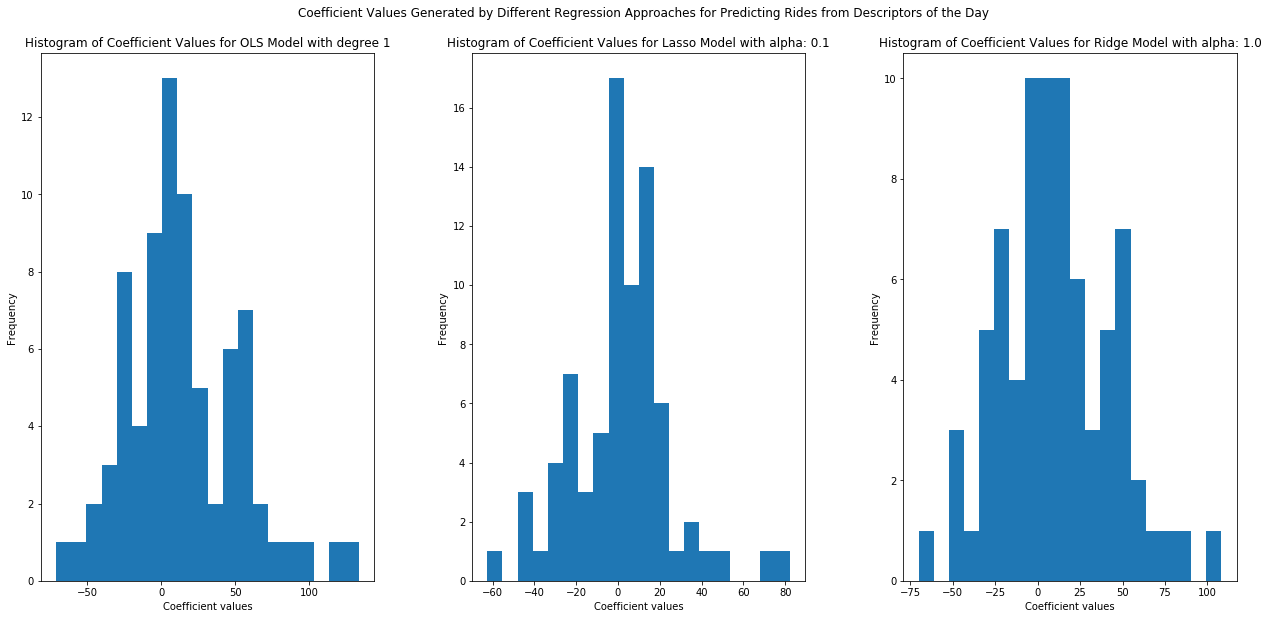

In [42]:
fig, ax = plt.subplots(figsize=(18,9), ncols=3)
ax = ax.ravel()
ax[0].hist(ols_model.params, bins=20)
ax[0].set_title('Histogram of Coefficient Values for OLS Model with degree 1');
ax[0].set_xlabel('Coefficient values');
ax[0].set_ylabel('Frequency');

ax[1].hist(fitted_lasso.coef_.flatten(), bins=20)
ax[1].set_title('Histogram of Coefficient Values for Lasso Model with alpha: {}'.format(lasso_a));
ax[1].set_xlabel('Coefficient values');
ax[1].set_ylabel('Frequency');

ax[2].hist(fitted_ridge.coef_.flatten(), bins=20)
ax[2].set_title('Histogram of Coefficient Values for Ridge Model with alpha: {}'.format(ridge_a));
ax[2].set_xlabel('Coefficient values');
ax[2].set_ylabel('Frequency');

fig.suptitle('Coefficient Values Generated by Different Regression Approaches for Predicting Rides from Descriptors of the Day\n')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

We observe that the highest frequency coefficients have magnitudes close to 0 for all regression approaches. This is because all three histograms are generally centered around 0. We notice that the coefficient values for OLS regression have a larger range (approximately -75 to 120) than for the Lasso (with range -60 to 80 approximately) or Ridge (with range approximately -75 to 100) regression. The Lasso model has the highest frequency of coefficients around 0 (approximately 16 coefficients) compared to Ridge regression (with closer to 9 coefficients of 0) and OLS regression (with only approximately 10 coefficients at 0). 

**5.6 The plots above show the overall distribution of...**

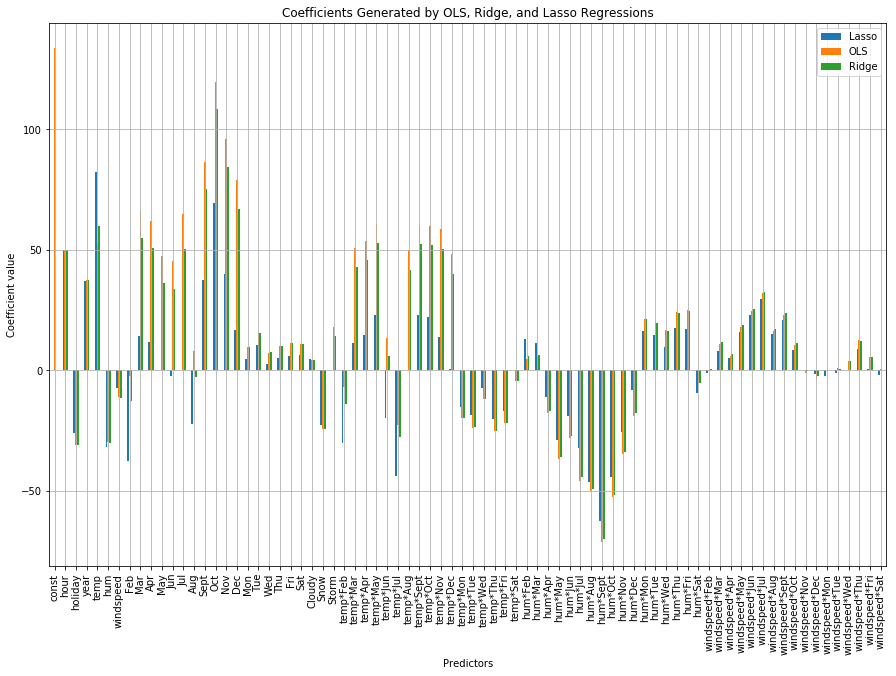

In [43]:
coeffs_df = {'OLS': ols_model.params, 'Ridge':fitted_ridge.coef_, 'Lasso':fitted_lasso.coef_}
coeffs_df = pd.DataFrame(data = coeffs_df)
coeffs_plot = coeffs_df.plot.bar(figsize=(15,10));
coeffs_plot.set_title('Coefficients Generated by OLS, Ridge, and Lasso Regressions');
coeffs_plot.set_xlabel('Predictors');
coeffs_plot.set_ylabel('Coefficient value');
coeffs_plot.grid(True)

#hint says to use xticks but we already have features shown on the x axis

**5.7 What trends do you see...**

In [44]:
# gives the regression approach that has the largest coefficient for each feature
winners = pd.DataFrame(abs(coeffs_df).idxmax(axis=1)) 

In [45]:
print('Proportion of OLS wins:', len(winners[winners[0]=='OLS'])/len(winners))
print('Proportion of Ridge wins:', len(winners[winners[0]=='Ridge'])/len(winners))
print('Proportion of Lasso wins:', len(winners[winners[0]=='Lasso'])/len(winners))

Proportion of OLS wins: 0.6538461538461539
Proportion of Ridge wins: 0.14102564102564102
Proportion of Lasso wins: 0.20512820512820512


We observe that the coefficient values obtained from each regression approach trend similarly overall since the grouped bars have comparable values in general (note also that there is a high frequency of coefficients near 0 for all regression approaches - see question 5.5's histograms for further support of this). In general, larger magnitudes for coefficients occur for the polynomial degree 1 terms compared to the interaction terms (as evidenced in the plot since more bars corresponding to the predictors that are not interaction terms have magnitudes >50). We can observe from the grouped bar plot that September, October, November, and December all showed relatively large coefficients as predictors, indicating that the number of rides tends to be increasing during these months. The predictors hum $\times$ May, hum $\times$ Jun, hum $\times$ Jul, hum $\times$ Aug, hum $\times$ Sept, hum $\times$ Oct, and hum $\times$ Nov also all tend to have relatively large negative values for their coefficients, which means that the effect of humidity on number of rides is different when it is each of these months (May through Nov). Specifically, the negative sign on the coefficient of these interaction terms indicates that when it is each of those months (May through Nov) the effect of humidity on the number of rides increases (the number of rides decreases). We also observe that the coefficients for the interaction terms involving windspeed and the days of the week are all relatively small and positive, which indicates that the effect of windspeed on the number of rides is generally unchanged for different days of the week. 

However, there are differences in the coefficients obtained from each regression approach. The largest coefficients occur for October as a predictor for OLS and Ridge regression approaches, which indicates that October tends to predict an increase of approximately 110 more rides. The largest coefficient occurs for the predictor temp for the Lasso regression, where there is a positive association between temperature and number of rides. OLS has the largest coefficient by magnitude for 65% of the predictors, compared to 14% for Ridge regression and 21% for Lasso (calculated in cells above; the observation that OLS has some coefficients with larger magnitudes is corroberated by the histograms in question 5.5 since the coefficients range from almost -75 to 120 for the OLS model while they range from approximately -60 to 80 for the Lasso model and -75 to 100 for the Ridge model). This makes sense since regularized regression (Ridge or Lasso) tend to shrink the beta estimates to help reduce overfitting and reduce the effect of predictors that have weak predictive power anyways. 

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

The get_design_mats function was useful for building training and testing datasets in a single step even though multiple processing phases were required (standardization, adding higher order terms, and adding interaction terms). If we had copy/pasted the model-building code instead of using this function, we may have forgotten to perform all steps in the same way for each dataset generated (for example, we may have forgotten to add the higher order polynomial terms with degree up to and including a specified degree). The function was wise in this problem because we intended to create training and testing datasets with the same preprocessing for each model, but if we had intended to train models with different sets of predictors (such as only having cubic terms but not the accompanying squared or degree 1 terms) it would have been inconvenient to have one comprehensive function built (and it may have been better in these cases to maintain multiple helper functions that could be more easily duplicated and modified than one all-encompassing get_design_mats function).

**6.2 What are the costs and benefits of applying ridge/lasso...**

Both Lasso and Ridge, though more computationally intensive than simple OLS (Ridge regression has a closed form solution, Lasso must be approximated analytically generally with iterative approaches), will help to reduce the effect of predictors that have a weak effect on the response (Lasso will nullify more predictors compared to Ridge so Lasso is better for feature selection, but both will reduce the magnitudes of extreme beta values) and will reduce variance by increasing bias (note that OLS is unbiased while Ridge is not) so that the model fits testing (but not necessarily training) data more appropriately. Setting a specific degree polynomial may be less computationally intensive than Ridge/Lasso (depending on the degree polynomial used) and can allow the user to be more intentional about which predictors are included (could be useful if a certain degree is suspected to have an effect on the response) but may produce a model that is difficult to interpret (assuming Ridge/Lasso has fewer polynomial terms) for all terms and more overfit to the training data (performing poorly in testing sets) compared to OLS, since polynomial regressions may have a high number of predictors (including some that do not have a strong effect on the response) and will generally exhibit multicolinearity among predictors (x, x^2, x^3, etc. will generally be multicolinear), which can contribute to more extreme beta estimates (and overfitting models) than would be obtained from OLS. Forward selecting polynomial features for the model may also help reduced overfitting (similarly to Ridge/Lasso but a benefit of it is that the user can have some control over which predictors can be selected on by choosing some predictors beforehand according to apriori knowledge) and is less computationally intensive than brute force testing to choose predictors (since forward selection is a greedy algorithm), but a cost of forward selecting compared to regularization is that the loss function for the model selected may correspond to only a local minimum (versus the global minimum for regularization) since forward selecting is a greedy algorithm.

**6.3 This pset posed a purely predictive goal: forecast ridership...**

If the goal is simply to help the Capital bikeshare program to predict the hourly demand for rental bikes, then interpretability is not important in this context as we have built a model that will do exactly what they asked for - predict hourly demand for rental bikes. If the lasso and ridge models predicted well, I would be very happy and satisifed with their utility as predictive models for hourly demand for rental bikes. It wouldn't matter if the coefficient values didn't make sense once interpreted as that might indicate that there is some unobserved relationship between the predictors or that there is some tradeoff between fitting and bias that caused coefficients to be uninterpretable, but none of these matter as we are only concerned about the utility of the model, which it is very good at predicting hourly demand for rental bikes. 

**6.4 Reflect back on our original goal of helping BikeShare predict...**

In question 3.1 we generated a multiple linear regression model that had issues with the assumptions of linear regression due to multicolinearity and abnormal residual distributions, while in question 4 we set specific polynomial degrees (1 through 8) and evaluated these models but found that after Ridge regularization on polynomial models with degree 1 through 8, the $R^2$ on the testing data for the best regularized polynomial model was better than the $R^2$ on the testing data for the best un-regularized polynomial model and than the polynomial of degree 1 model made in 5.4. The $R^2$ = 0.6415 for this fitted Ridge regression model with degree 8 and lambda 0.1 is sufficiently high and does accomplish the goal of predicting the rides per hour so that the company can make more bikes available during peak hours and increase revenue. Since the goal is *purely predictive* and the predictors are not generally modifiable by the company, the company should track the used predictors ('hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'), calculate the relevant polynomial and interaction terms, and then generate the predicted number of rides for those conditions so that they can make that number of bikes available.